<a href="https://colab.research.google.com/github/sachsac/teaching_data/blob/main/TA_Hours_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
df = pd.read_excel('/content/drive/MyDrive/Work/Independent Projects/TA work/TA helping.xlsx')
df.drop(columns='Student', inplace = True) #dropping for anonymity
df.head()

,Cohort,Time,Date,Day of week,Time in Military,Off Hours Request? Y/N
0,Sherlin,18:12:00,2021-12-22,Wed,1812,No
1,Sherlin,19:27:00,2021-12-12,Sun,1927,Yes
2,Josh,20:16:00,2022-01-05,Wed,2016,No
3,Josh,23:05:00,2021-12-09,Thu,2305,No
4,Josh,21:25:00,2021-12-08,Wed,2125,No


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Cohort                  45 non-null     object        
 1   Time                    47 non-null     object        
 2   Date                    47 non-null     datetime64[ns]
 3   Day of week             47 non-null     object        
 4   Time in Military        47 non-null     int64         
 5   Off Hours Request? Y/N  47 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 2.3+ KB


# Can we predict when a student will ask Mandy for help?
( A Regression Problem)

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

In [158]:
X = df.drop(columns = 'Time in Military')
y = df['Time in Military']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [160]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [161]:
num_tuple = (scaler, num_selector)
cat_tuple = (encoder, cat_selector)

In [162]:
col_trans = make_column_transformer(num_tuple, cat_tuple)
col_trans.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9fd812f810>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9fd812ff10>)])

In [163]:
X_train = col_trans.transform(X_train)
X_test = col_trans.transform(X_test)

In [164]:
#imputer = SimpleImputer(missing_values = np.nan,
                       # strategy ='most frequent')
#X_train = imputer.fit_transform(X_train)
#X_test = imputer.transform(X_test)

In [165]:
#baseline prediction (average time)
y_train.mean()
#about 5:17pm

1717.4857142857143

In [166]:
reg = LinearRegression()
reg.fit(X_train, y_train) #all preprocessing has already been done and put back into X_train/y_train

LinearRegression()

In [167]:
train_preds = reg.predict(X_train)
test_preds = reg.predict(X_test)
r2train = reg.score(X_train,y_train)*100  #*100 puts it into a number that can be displayed as a percentage rather than a decimal that represents the percentage
r2test = reg.score(X_test, y_test)*100
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
print('R2 Training Score: {:.3f}'.format(r2train) + '%')
print('R2 Testing Score: {:.3f}'.format(r2test) + '%') 
print('Root Mean Squared Error of Training: {:.3f}'.format(rmse_train))
print('Root Mean Squared Error of Testing: {:.3f}'.format(rmse_test))

R2 Training Score: 100.000%
R2 Testing Score: -11.596%
Root Mean Squared Error of Training: 0.000
Root Mean Squared Error of Testing: 344.012


## Does Random Forest perform better?

In [168]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [169]:
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)
r2train = rf.score(X_train,y_train)*100  #*100 puts it into a number that can be displayed as a percentage rather than a decimal that represents the percentage
r2test = rf.score(X_test, y_test)*100
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
print('R2 Training Score: {:.3f}'.format(r2train) + '%')
print('R2 Testing Score: {:.3f}'.format(r2test) + '%') 
print('Root Mean Squared Error of Training: {:.3f}'.format(rmse_train))
print('Root Mean Squared Error of Testing: {:.3f}'.format(rmse_test))
#does perform better, but still not a very reliable model

R2 Training Score: 84.949%
R2 Testing Score: 5.671%
Root Mean Squared Error of Training: 168.509
Root Mean Squared Error of Testing: 316.280


Regression models do not reliably predict a time that a student would approach TA because of the negative test R2 score. A negative score reflects performance that is worse than the average/baseline (horizontal line). With the Random forests, performance on test is still way too high. This is likely due to the small sample size and more data would be needed to create a more reliable model.

# Can we predict if a student will contact after hours vs during hours?
(A Classification Problem)
Although the Regression Problem was unable to be tackled using this data, can it more reliably help with a classification question?

In [170]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [171]:
#although it is the same data set, we need to redo our train test split and preprocessing steps
X = df.drop(columns = 'Off Hours Request? Y/N')
y = df['Off Hours Request? Y/N']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [173]:
#code to check the split of our variables
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts)))

Counts of each class in Training: {'No': 22, 'Yes': 13}
Counts of each class in Test: {'No': 7, 'Yes': 5}


In [174]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [175]:
num_tuple = (scaler, num_selector)
cat_tuple = (encoder, cat_selector)

In [176]:
col_trans = make_column_transformer(num_tuple, cat_tuple)
col_trans.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9fd813ec50>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9fd813ea10>)])

In [177]:
X_train = col_trans.transform(X_train)
X_test = col_trans.transform(X_test)

In [178]:
print('Baseline Training Accuracy:')
print(y_train.value_counts(normalize=True))
print()
print('Baseline Testing Accuracy:')
print(y_test.value_counts(normalize=True))  

Baseline Training Accuracy:
No     0.628571
Yes    0.371429
Name: Off Hours Request? Y/N, dtype: float64

Baseline Testing Accuracy:
No     0.583333
Yes    0.416667
Name: Off Hours Request? Y/N, dtype: float64


In [179]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Logistic Regression Performance')
print(metrics.classification_report(y_test, y_pred))
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_test)
print('KNN Performance')
print(metrics.classification_report(y_test, y_pred2))
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)
print('XGB Performance')
print(metrics.classification_report(y_test, y_pred3))


Logistic Regression Performance
              precision    recall  f1-score   support

          No       0.78      1.00      0.88         7
         Yes       1.00      0.60      0.75         5

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.81        12
weighted avg       0.87      0.83      0.82        12

KNN Performance
              precision    recall  f1-score   support

          No       0.70      1.00      0.82         7
         Yes       1.00      0.40      0.57         5

    accuracy                           0.75        12
   macro avg       0.85      0.70      0.70        12
weighted avg       0.82      0.75      0.72        12

XGB Performance
              precision    recall  f1-score   support

          No       0.88      1.00      0.93         7
         Yes       1.00      0.80      0.89         5

    accuracy                           0.92        12
   macro avg       0.94      0.90      0.91        12
weighted a

XGB actually performs very well for this problem before hypertuning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


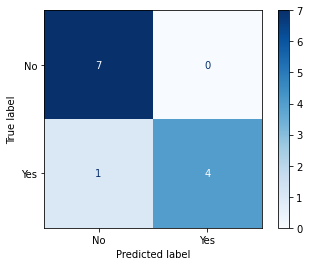

In [180]:
plot_confusion_matrix(xgb, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.suptitle('');
#the confusion matrix shows us visually what the classification report says
#however, it also really shows us how small this data set is